# Lab exercise 1: Stochastic Simulation and Monte Carlo


## SSA (Gillespies Algorithm)

## Changed for Mini Project 1

### The Lotka-Volterra Oscillator

To analyse the predator-prey system, we will consider the following set of chemical reactions, corresponding to the three possible **reactions** or **events** incorporated into the model. They represent the
**Lotka-Volterra model** of predator-prey interactions in a simple ecology. Here, $R$ represents the number (or concentration) of prey, e.g. rabbits, and $F$ represents the number (or concentration) of predators, e.g. foxes. The first reaction incorporates prey reproduction into our model, with $\alpha$ denoting the reproduction rate of each prey. The second reaction incorporates predator reproduction per prey, with $\beta$ denoting the rate of encounters between prey and predator animals. In other words, the predator consumes prey and reproduces at a rate of $\beta$. The third and final reaction incorporates predator mortality, with $\gamma$ denoting the rate at which predators are removed from the ecosystem.

\begin{align*}
R &\xrightarrow{\alpha} 2R\\
R+F &\xrightarrow{\beta} 2F \\
F &\xrightarrow{\gamma} \emptyset
\end{align*}

In this part of the Lab, we obtain both stochastic and deterministic solutions for this model. This will also assist you in completing your mini-project on genetic oscillators. You have two options: (1) follow the lecture note presentation and use our code, or (2) use Python's built-in GillesPy2 library. The first option will provide you with a deeper insight into and understanding of how the SSA algorithm functions, while the second option may offer a simpler implementation.

### Option 1: SSA from lecture notes

We will use the SSA to simulate the system. SSA uses the _**propensity**_ of each reaction, derived from the reaction rates $\alpha$, $\beta$ and $\gamma$, to obtain a stochastic simulation of the system. The propensity of a reaction is proportional to the probability that the reaction will occur given the current state of the system. In each iteration, a reaction is drawn from a **discrete distribution** with a probability proportional to the propensity of each reaction. The time interval after which the reaction will occur is drawn from an **exponential distribution**, and the system is updated accordingly. Don't worry about the details of the algorithm, we will use SSA as a tool and focus on the stochastic simulation results.

Assume that $\textbf y = [y_1,y_2] = [F,R]$ is the state vector, and specify the propensity functions and state-change vectors as below:
$$
\begin{array}{llll}
1.&R \xrightarrow{\alpha} 2R      & v_1 = [0,1], & w_1 = \alpha y_2   \\
2.&R+F\xrightarrow{\beta} 2F      & v_2 = [1,-1], & w_2 = \beta y_1y_2\\
3.&F\xrightarrow{\gamma} \emptyset& v_3 = [-1,0], & w_3 = \gamma y_1
\end{array}
$$

We also assume $a = w_1+w_2+w_3$ and $p_j = \frac{w_j}{a}$ for $j=1,2,3$. Here, $p_j$ is the probability of reaction $j$ to happen.

In the SSA algorithm, it is necessary to sample from both the exponential distribution and the discrete distribution. The Python functions for these operations are provided below. Both algorithms employ the Inverse Transform Method (ITM). Execute the following code snippets sequentially.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Generate N random numbers from exponential distribution
def RandExp(lam,N):
    U =  np.random.rand(N)
    X = -1/lam*np.log(1-U) # RECALL: Inverse Transform
    return X

In [ ]:
#  Generate N random numbers from discrete distribution
#   with sorted state vector x and corresponding probability vector p
def RandDisct(x,p,N):
    cdf = np.cumsum(p)
    U = np.random.rand(N)
    idx = np.searchsorted(cdf, U)
    return x[idx]

Then, the SSA algorithm can be written as follows. The input arguments include the vector
- `Initial` (representing the initial state $\textbf y_0$),
- the state-change matrix `StateChangeMat` (which stacks the state-change vectors on top of each other to form the state-change matrix), and
- the final time `FinalTime`.

The output comprises the list of
- all time levels `AllTimes` and
- the solution list `AllStates`, where the first element of list corresponds to the initial state $\textbf y_0$, the second element to the solution at $t_1$ (i.e., $\textbf y_1$), and so on.

You can review the function to observe how the subsequent time step is sampled, how the reaction to be occured is sampled, and how the state is updated.

In [ ]:
def SSA(Initial, StateChangeMat, FinalTime):
   # Inputs:
   #  Initial: initial conditins of size (StateNo x 1)
   #  StateChangeMat: State-change matrix of size (ReactNo, StateNo)
   #  FinalTime: the maximum time we want the process be run

   # Output:
   #  AllTimes: the list of all selected time levels
   #  AllStates: the list of all state values at corresponding time levels

    [m,n] = StateChangeMat.shape
    ReactNum = np.array(range(m))
    AllTimes = {}   # define a list for storing all time levels
    AllStates = {}  # define a list for storing all states at all time levels
    AllStates[0] = Initial
    AllTimes[0] = [0]
    k = 0; t = 0; State = Initial
    while True:
        w = PropensityFunc(State, m)     # propensities (vector of size (3,))
        a = np.sum(w)                    # normalizing (all add up to 1, and each value between 0-1)
        tau = RandExp(a,1)               # WHEN the next reaction happens
        t = t + tau                      # update time
        if t > FinalTime:
            break
        which = RandDisct(ReactNum,w/a,1)             # WHICH reaction occurs
        State = State + StateChangeMat[which.item(),] # Uppdate the state
        k += 1
        AllTimes[k] = t
        AllStates[k] = State
    return AllTimes, AllStates

The above SSA function can be used to solve various stochastic models (including that of your mini-project). To do so, you just need to define the propensity function, form the state-change matrix, and provide model parameters. Let's apply the SSA to solve the predator-prey problem mentioned earlier.
In the cell below we assign the constant rates $\alpha=1$, ${\beta}=0.005$, and ${\gamma}=0.6$, the initial state $\textbf y_0=[50,100]$, and the final time $30$.  Also, we form the state-change matrix by stacking the state-change vectors on top of each other.

In [ ]:
alpha, beta, gamma = 1, 0.005, 0.6  # constant rates
Initial = [50,100]                  # Initial number of foxes and rabbits
FinalTime = 30                      # final time of simulation

StateChangeMat = np.array([         # State-Change Matrix
                          [0,  1],
                          [1, -1],
                          [ -1,0]])

Now, we define the pronensity function as below:

In [ ]:
# Propensity functions (for predator-prey model)
def PropensityFunc(State,ReactNo):
    # State: state variable [F,R]
    # ReactNo: number of reactions
    w = np.zeros(ReactNo)
    F,R = State
    w[0] = alpha*R
    w[1] = beta*F*R
    w[2] = gamma*F
    return w

Everything is ready, just run the cell below to plot the results. What do you observe? Run it several times.


<ipython-input-2-eaca59a8e18f>:4: RuntimeWarning: divide by zero encountered in scalar divide
  X = -1/lam*np.log(1-U) # RECALL: Inverse Transform


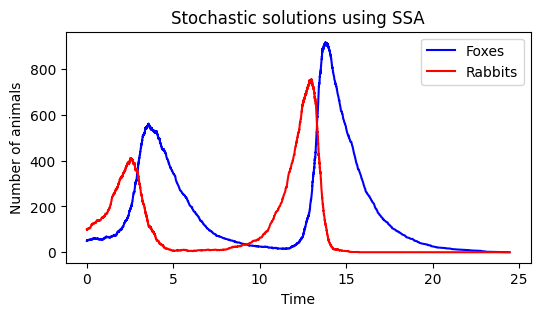

In [ ]:
# SSA Simulation of predator-prey model (Foxes and Rabbits)

Times, States = SSA(Initial, StateChangeMat, FinalTime)

# retrieve state variables F and R from the output list
n = len(Times)
t = [Times[i][0] for i in range(n)]
F = [States[i][0] for i in range(n)]
R = [States[i][1] for i in range(n)]

plt.figure(figsize = (6, 3))
plt.plot(t,F,linestyle = '-', color = 'blue',label = 'Foxes')
plt.plot(t,R,linestyle = '-', color = 'red',label = 'Rabbits')
plt.xlabel('Time');
plt.ylabel('Number of animals');
plt.title('Stochastic solutions using SSA')
plt.legend()
plt.show()


In a `for` loop plot multiple (for example 10) trajectories. What do you observe?

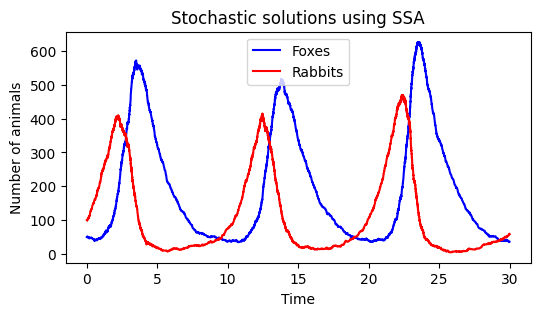

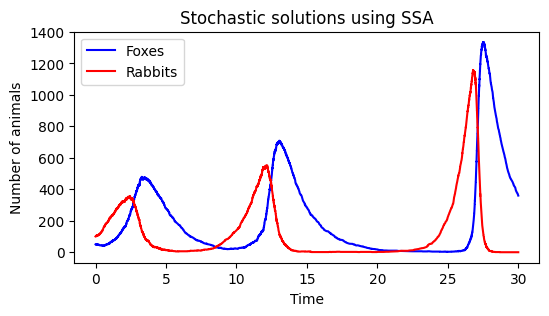

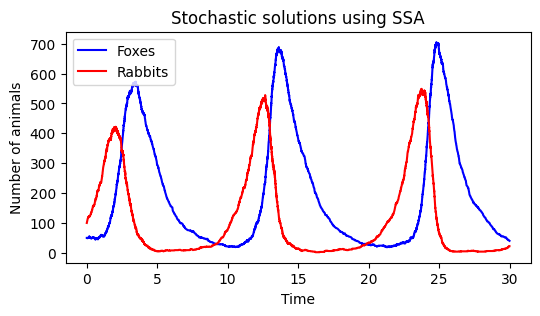

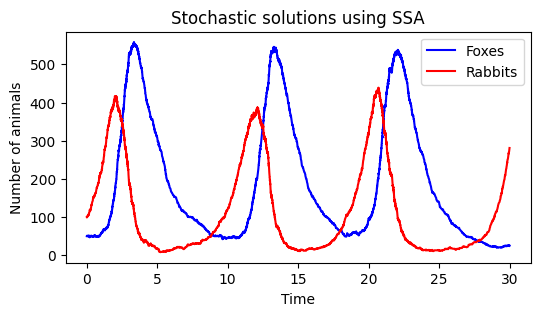

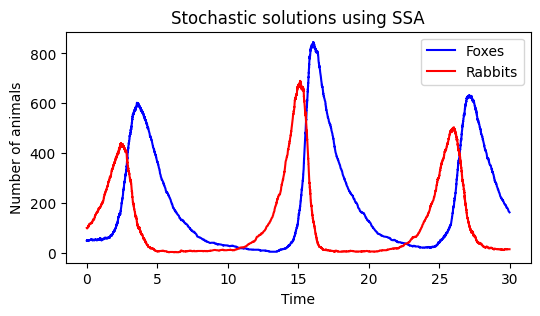

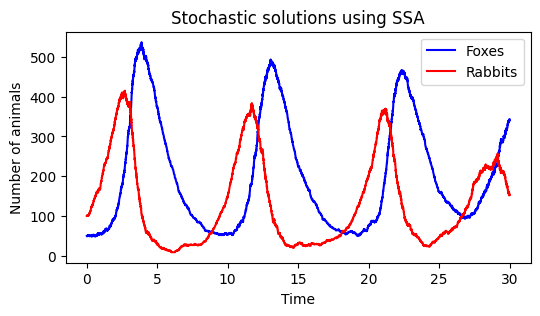

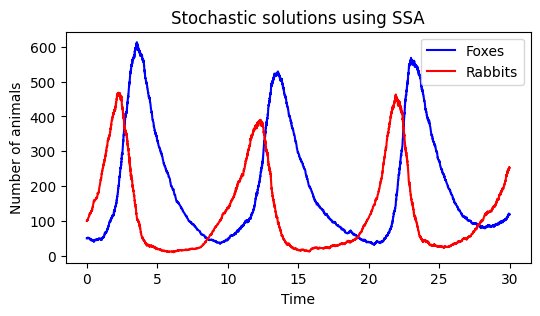

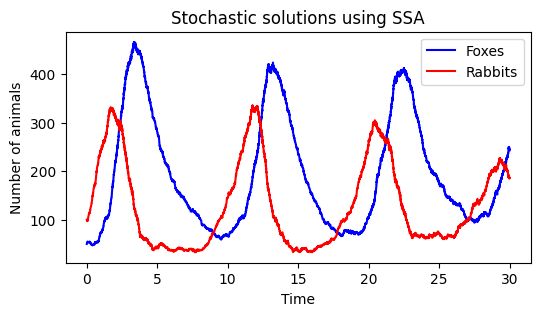

<ipython-input-2-eaca59a8e18f>:4: RuntimeWarning: divide by zero encountered in scalar divide
  X = -1/lam*np.log(1-U) # RECALL: Inverse Transform


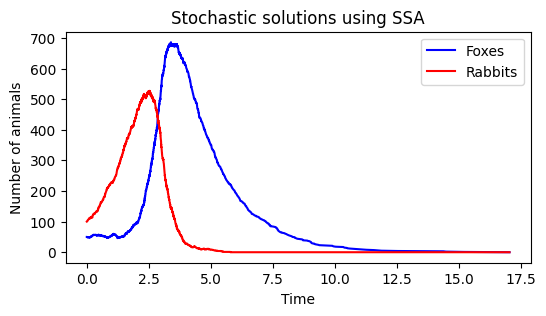

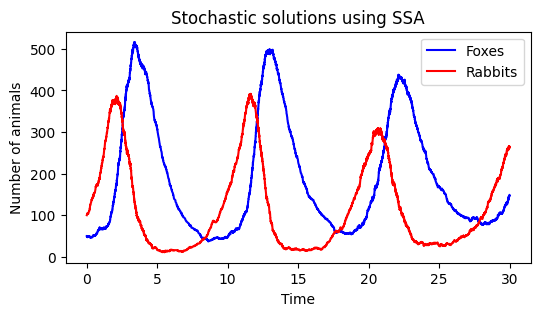

In [ ]:
# enter your code here
for i in range(10):
  Times, States = SSA(Initial, StateChangeMat, FinalTime)

  # retrieve state variables F and R from the output list
  n = len(Times)
  t = [Times[i][0] for i in range(n)]
  F = [States[i][0] for i in range(n)]
  R = [States[i][1] for i in range(n)]

  plt.figure(figsize = (6, 3))
  plt.plot(t,F,linestyle = '-', color = 'blue',label = 'Foxes')
  plt.plot(t,R,linestyle = '-', color = 'red',label = 'Rabbits')
  plt.xlabel('Time');
  plt.ylabel('Number of animals');
  plt.title('Stochastic solutions using SSA')
  plt.legend()
  plt.show()

Play around with the initial conditions and rates. Run the cells and view the different results. What different system behaviors do you observe, i.e. what happens to the prey and predator populations over time?

<ipython-input-2-eaca59a8e18f>:4: RuntimeWarning: divide by zero encountered in scalar divide
  X = -1/lam*np.log(1-U) # RECALL: Inverse Transform


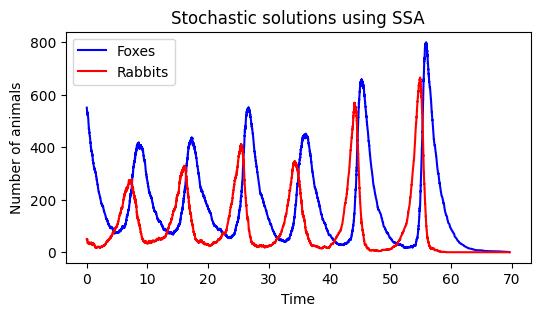

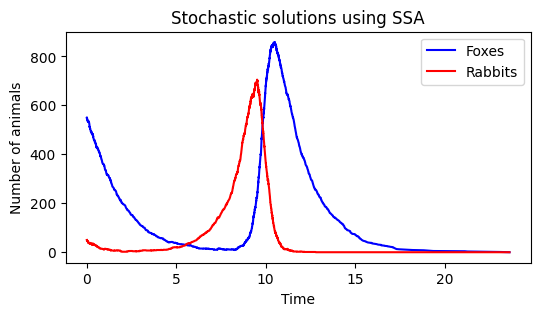

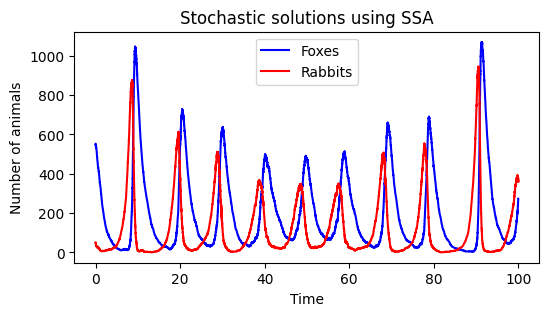

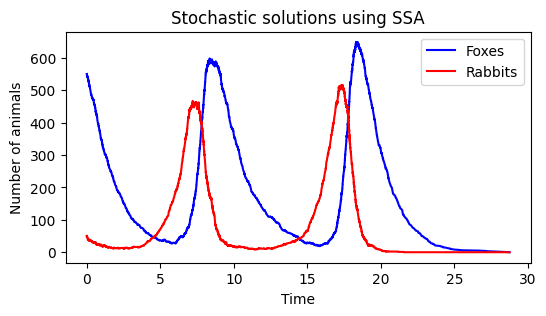

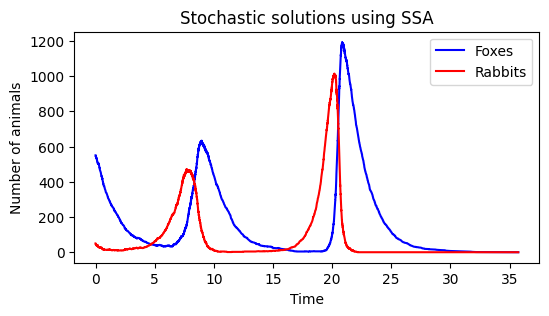

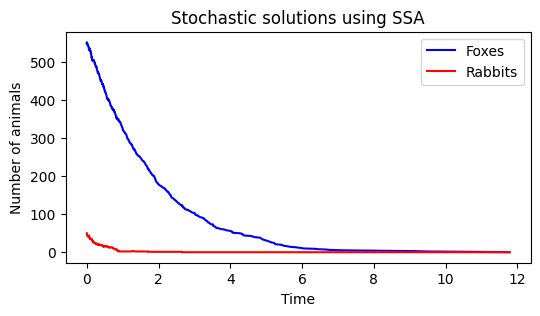

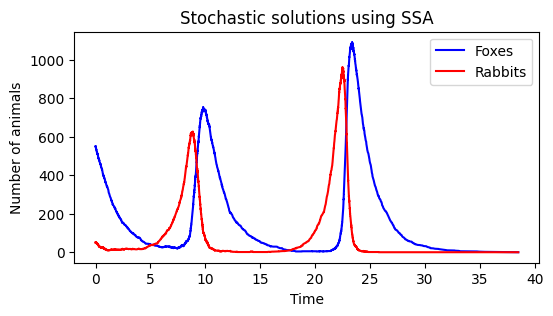

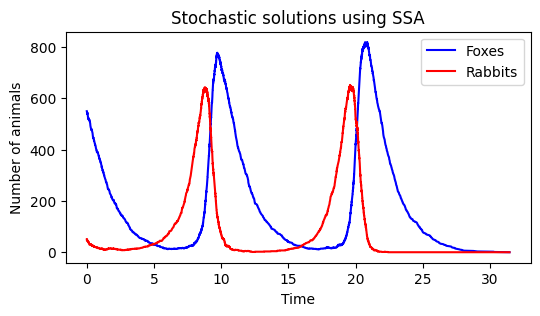

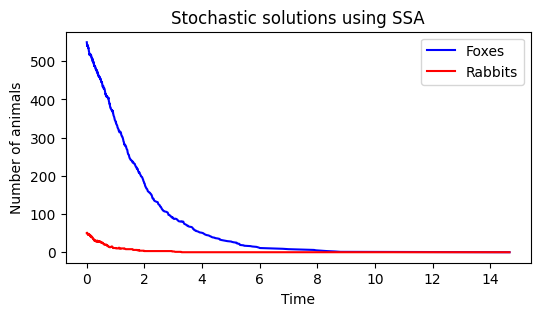

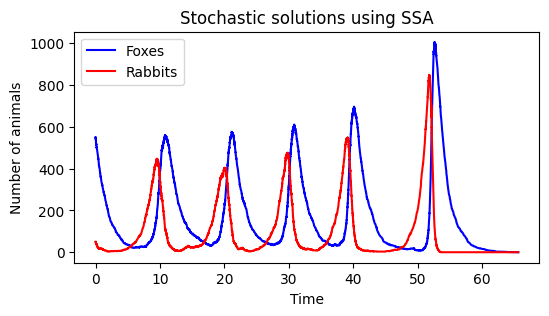

In [ ]:
alpha, beta, gamma = 1, 0.005, 0.6  # constant rates
Initial = [550,50]                  # Initial number of foxes and rabbits
FinalTime = 100                      # final time of simulation

# enter your code here
for i in range(10):
  Times, States = SSA(Initial, StateChangeMat, FinalTime)

  # retrieve state variables F and R from the output list
  n = len(Times)
  t = [Times[i][0] for i in range(n)]
  F = [States[i][0] for i in range(n)]
  R = [States[i][1] for i in range(n)]

  plt.figure(figsize = (6, 3))
  plt.plot(t,F,linestyle = '-', color = 'blue',label = 'Foxes')
  plt.plot(t,R,linestyle = '-', color = 'red',label = 'Rabbits')
  plt.xlabel('Time');
  plt.ylabel('Number of animals');
  plt.title('Stochastic solutions using SSA')
  plt.legend()
  plt.show()

### Deterministic Solution by an ODE solver

The defined predator-prey system can be modelled as a system of ordinary differential equations, the so-called **Lotka-Volterra-equations** defined below. The system can then be simulated by numerically solving this system of differential equations.

\begin{align*}
&\frac{dF}{dt} = \beta FR - \gamma F \\
&\frac{dR}{dt} = \alpha R -\beta FR
\end{align*}

For solving this system we can use the ODE solver `solve_ivp` from the `scipy.integrate` library. This solver employ some adaptive numerical methods for solving a system of first-order differential equations. The default solver is Runge-Kutta-Fehlberg (RK45) method. Run the cell below and report your observation. How do you compare it with stochastic solutions?

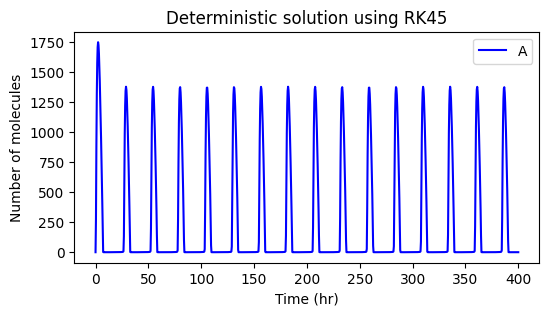

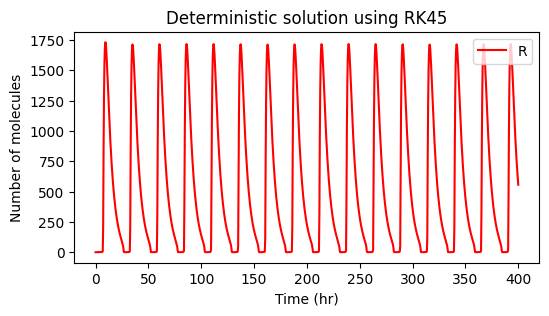

In [93]:
from scipy.integrate import solve_ivp
import numpy as np
from matplotlib import pyplot as plt

alpha_A = 50
alpha_A_prim = 500
alpha_R = 0.01
alpha_R_prim = 50
beta_A = 50
beta_R = 5
delta_MA = 10
delta_MR = 0.5
delta_A = 1
delta_R = 0.2
gamma_A = 1  # mol^-1 * hr^-1
gamma_R = 1
gamma_C = 2
theta_A = 50  # h^-1
theta_R = 100

Initial = [1, 1, 0, 0, 0, 0, 0, 0, 0]
t_steps = 400

def Predator_Prey(t, y):
    D_A, D_R, D_A_prim, D_R_prim, M_A, A, M_R, R, C = y
    yprime = np.zeros(9)
    yprime[0] = theta_A * D_A_prim - gamma_A * D_A * A  # dD_A/dt
    yprime[1] = theta_R * D_R_prim - gamma_R * D_R * A  # dD_R/dt
    yprime[2] = gamma_A * D_A * A - theta_A * D_A_prim  # dD_A_prim/dt
    yprime[3] = gamma_R * D_R * A - theta_R * D_R_prim  # dD_R_prim/dt
    yprime[4] = alpha_A_prim * D_A_prim + alpha_A * D_A - delta_MA * M_A  # dMA/dt
    yprime[5] = (
        beta_A * M_A
        + theta_A * D_A_prim
        + theta_R * D_R_prim
        - (A * (gamma_A * D_A + gamma_R * D_R + gamma_C * R + delta_A))
    )  # dA/dt
    yprime[6] = alpha_R_prim * D_R_prim + alpha_R * D_R - delta_MR * M_R  # dMR/dt
    yprime[7] = beta_R * M_R - gamma_C * A * R + delta_A * C - delta_R * R  # dR/dt
    yprime[8] = gamma_C * A * R - delta_A * C  # dC/dt
    return yprime

teval = np.linspace(0, t_steps, 1000)  # a fine evaluation time samples
sol = solve_ivp(Predator_Prey, [0, t_steps], Initial, t_eval=teval, method="RK45")

plt.figure(figsize=(6, 3))
plt.plot(sol.t, sol.y[5], linestyle="solid", color="blue", label="A")
plt.xlabel("Time (hr)")
plt.ylabel("Number of molecules")
plt.title("Deterministic solution using RK45")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(sol.t, sol.y[7], linestyle="solid", color="red", label="R")
plt.xlabel("Time (hr)")
plt.ylabel("Number of molecules")
plt.title("Deterministic solution using RK45")
plt.legend(loc="upper right")
plt.show()

To compare the deterministic solution with stochastic solutions, plot the deterministic and 10 stochastic solutions of foxes' (or rabbits') population in the same figure. What do you observe? How do you compare this with that of the SIR model in the lecture notes?

In [ ]:
# enter your code here


### Option 2: Working with Python's GillesPy2 library

In this part, we will investigate the dynamics of the predator-prey system using **Python's GillesPy2 library**.

a) In the cell below, you will find an implementation of the Lotka-Volterra model using the **GillesPy2** library. Read through the code and make sure you understand how each component of the Lotka-Volterra model, as defined above, is implemented. What is the initial number of predators in this system? What is the prey reproduction rate? For how many time steps will the model be simulated?

In [28]:
# You don't need to run this cell if you are using the StochSS environment.
# However, if you are working in Google Colab or any other platform, you must run this cell to install gillespy2 first.

%pip install gillespy2

  Using cached setuptools-75.8.0-py3-none-any.whl.metadata (6.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 13.3 MB/s eta 0:00:0031m13.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 13.5 MB/s eta 0:00:0031m14.6 MB/s eta 0:00:01
Using cached setuptools-75.8.0-py3-none-any.whl (1.2 MB)

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
import numpy as np
import gillespy2
from gillespy2 import Model, Species, Reaction, Parameter, RateRule, AssignmentRule, FunctionDefinition
from gillespy2 import EventAssignment, EventTrigger, Event

In [30]:
class Lotkavolterra_Oscillator(Model):
    def __init__(self, parameter_values=None):
        Model.__init__(self, name="Lotkavolterra_Oscillator")
        self.volume = 1

        # Define the parameters of the system
        self.add_parameter(Parameter(name="alpha", expression=1))     # Initial value: 1
        self.add_parameter(Parameter(name="beta", expression=0.005))  # Initial value: 0.005
        self.add_parameter(Parameter(name="gamma", expression=0.6))   # Initial value: 0.6

        # Add species and define the initial condition (count or concentration) of each species
        self.add_species(Species(name="R", initial_value=100, mode="discrete"))    # Initial value: 100
        self.add_species(Species(name="F", initial_value=50, mode="discrete"))     # Initial value: 50

        # Reactions
        self.add_reaction(Reaction(name="r1", reactants={'R': 1}, products={'R': 2}, rate=self.listOfParameters["alpha"]))
        self.add_reaction(Reaction(name="r2", reactants={'R': 1, 'F': 1}, products={'F': 2}, rate=self.listOfParameters["beta"]))
        self.add_reaction(Reaction(name="r3", reactants={'F': 1}, products={}, rate=self.listOfParameters["gamma"]))

        # Timespan
        self.timespan(np.linspace(0, 30, 1000))

b) Run the cells below to initialize the Lotka-Volterra oscillator and simulate the system using SSA. Plot the results. What do you observe? Hint: Run the import-cell and the cell containing the Lotka-Volterra oscillator class before running the cells below.

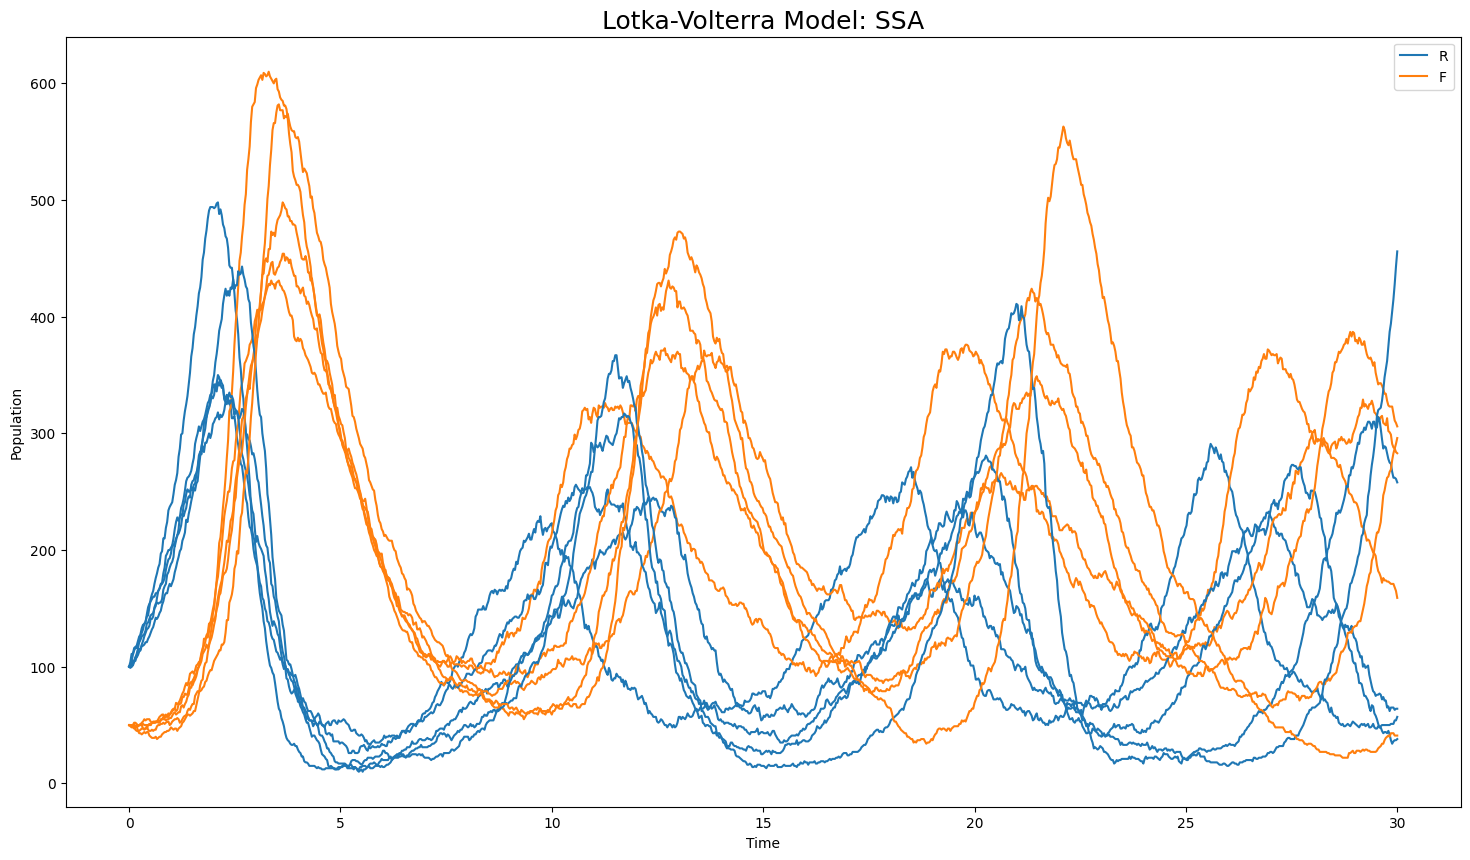

In [31]:
model = Lotkavolterra_Oscillator()
results = model.run(algorithm = "SSA", number_of_trajectories = 5)
results.plot(yaxis_label='Population', title='Lotka-Volterra Model: SSA')


c) Repeat (b) multiple times and compare the trajectories. What do you observe? Hint: You can run multiple trajectories at the same time by changing the `number_of_trajectories`-argument in `model.run()`. If you want to display the trajectories in different graphs, you can insert `multiple_graphs = True` as an argument to the plot-function.



In [ ]:
# enter your code here

You can also utilize the standard `matplotlib.pyplot` library for creating plots. For instance, the output from the previous cell consists of 5 simulations stored in the `results` list, each with the suffixes `.time`, `.R`, and `.F`. To access the variables and generate plots, you can write (for example for the first simulation):

In [ ]:
t = results[0]['time']
F = results[0]['F'];
R = results[0]['R'];

plt.figure(figsize = (6, 3))
plt.plot(t,R,linestyle = 'solid', color='blue', label = 'Rabbits')
plt.plot(t,F,linestyle = 'solid', color='red', label = 'Foxes')
plt.xlabel('Time'); plt.ylabel('Number of animals')
plt.legend(loc='upper right')
plt.show()


d) Run the model for a large number of trajectories, e.g. 500. The following code snippet will plot the mean and standard deviation of the resulting simulation results for the predator (species "F"): `results.plot_mean_stdev(included_species_list=["F"])` .

In [ ]:
# enter your code here

e) Play around with the initial conditions and model parameters defined in the Lotka-Volterra oscillator class. Run the cell below and view the different results. What different system behaviors do you observe, i.e. what happens to the prey and predator populations over time? Hint: Don't forget to re-run the cell defining the model class when you make changes there.

In [ ]:
model = Lotkavolterra_Oscillator()
results = model.run(algorithm = "SSA", number_of_trajectories=2)
results.plot(yaxis_label='Population', title='Lotka-Volterra Model: SSA', multiple_graphs=True)


### Deterministic solution in GillesPy2

Simulate the system again using the implemented Lotka-Volterra oscillator, but this time use an ODE-solver instead of SSA. You can do this by simply changing the algorithm to 'ODE' in the following code snippet. What happens when you run the model multiple times? Why?

In [ ]:
model = Lotkavolterra_Oscillator()
results = model.run(algorithm = "ODE")
results.plot(yaxis_label='Population', title='Lotka-Volterra Model: ODE')

g) Play around with the parameters and initial conditions. What different system behaviors do you observe?

In [ ]:
# enter your code here




_**To think about:**_

* Is the Lotka-Volterra model realistic? In reality, external factors impact the growth of the predator and prey population, for example environmental factors. Moreover, there are certain assumptions implicit in the model, such as predators having limitless appetite etc, and there are usually more complex forms of dependencies between different
animal species. However, the model can be modified to take such situations into account and variants of the
Lotka-Volterra model are used in practice. More complicated models can be used to simulate nutrition chains in an ecosystem, such as plankton → roach and perch → pike in a lake. These kinds of simulations can be used to predict how an environmental
change leading to a decreased plankton population will affect the entire ecosystem in a lake. _You can read more here:_ https://en.wikipedia.org/wiki/Lotka-Volterra_equations
* The GillesPy2-library can be be used to simulate many different kinds of stochastic biochemical processes using SSA, by defining a different set of species involved in a different set of chemical reactions. In this case, the species can be different kinds of molecules. If you go to _Tutorial_ in the StochSS main menu, you can find a simple example of a protein decay simulation.